In [3]:
# Imports
import os
import random
from glob import glob
import cv2 
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

import argparse
#import torch
#import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

from collections import Counter

In [ ]:
import numpy as np
import torch
import torchvision.models as models
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from collections import Counter

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx].astype(np.uint8)
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Load the data(images)
x_npz = np.load("data/x_images_arrays.npz")
X = x_npz["arr_0"]
y_npz = np.load("data/y_labels_arrays.npz")
Y = y_npz["arr_0"]

print(np.array(X).shape)
print(np.array(Y).shape)

# Separete the data into train, val and test sets
# 80% train, 10% val, 10% test
x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.2,random_state=1, stratify=Y)

x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp)

print(np.array(x_train).shape)
print(np.array(x_val).shape)
print(np.array(x_test).shape)
# (3045, 128, 128, 3) 
# (381, 128, 128, 3)
# (381, 128, 128, 3)

# Transform the data to tensor
# Define a transform
transform = transforms.Compose([
            #transforms.Resize((28, 28)),
            transforms.ToPILImage(),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

# Apply the transform to the data
dataset_train = CustomImageDataset(x_train, y_train, transform=transform)
dataset_val = CustomImageDataset(x_val, y_val, transform=transform)
dataset_test = CustomImageDataset(x_val, y_val, transform=transform)

img, label = dataset_train[0]
print(img.shape, label) # [grayscale=1, size=128, size=128] label=0 ('Nothing')
print(dataset_train.__len__()) # 3045 images
print(dataset_val.__len__()) # 381 images
print(dataset_test.__len__()) # 381 images


# Verificar a distribuição de classes antes do SMOTE
print("Distribuição de classes no conjunto de treino (antes do SMOTE):")
print(Counter(y_train))

# Extrair features com ResNet18
model = models.resnet18(pretrained=True)
model.eval()
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove a última camada
features = []
labels = []
with torch.no_grad():
    for img, label in dataset_train:
        img = img.unsqueeze(0)  # Adiciona dimensão de batch
        feature = model(img).flatten().numpy()
        features.append(feature)
        labels.append(label)
features = np.array(features)
labels = np.array(labels)

# Normalizar features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Aplicar SMOTE
smote = SMOTE(random_state=42)
features_resampled, labels_resampled = smote.fit_resample(features, labels)

# Verificar a distribuição de classes após o SMOTE
print("Distribuição de classes no conjunto de treino (após o SMOTE):")
print(Counter(labels_resampled))

# Mapear features resampleadas para imagens originais
# Como SMOTE gera features sintéticas, usamos as imagens originais mais próximas
from sklearn.neighbors import NearestNeighbors

# Ajustar NearestNeighbors para encontrar as imagens originais mais próximas
nn = NearestNeighbors(n_neighbors=1)
nn.fit(features)  # Usar as features originais
_, indices = nn.kneighbors(features_resampled)  # Encontrar o índice da imagem original mais próxima
indices = indices.flatten()

# Criar novas listas de imagens e labels balanceadas
x_train_resampled = x_train[indices]  # Selecionar imagens originais correspondentes
y_train_resampled = labels_resampled  # Usar as labels geradas pelo SMOTE

# Criar novo dataset balanceado
dataset_train_resampled = CustomImageDataset(x_train_resampled, y_train_resampled, transform=transform)

# Criar DataLoader com o dataset balanceado
batch_size = 32
train_loader = DataLoader(dataset_train_resampled, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)


# Verificar o tamanho do novo dataset
print(f"Tamanho do dataset de treino balanceado: {len(dataset_train_resampled)} imagens")

(3807, 128, 128, 3)
(3807,)
(3045, 128, 128, 3)
(381, 128, 128, 3)
(381, 128, 128, 3)
torch.Size([1, 128, 128]) 0
3045
381
381
Distribuição de classes no conjunto de treino (antes do SMOTE):
Counter({np.int64(0): 2435, np.int64(2): 402, np.int64(1): 208})


c:\Users\giueg\.virtualenvs\TCC_25-OGy0qkdu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\giueg\.virtualenvs\TCC_25-OGy0qkdu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Distribuição de classes no conjunto de treino (após o SMOTE):
Counter({np.int64(0): 2435, np.int64(2): 2435, np.int64(1): 2435})
Tamanho do dataset de treino balanceado: 7305 imagens


In [6]:
# Salvar os dados balanceados em um arquivo .npz
np.savez('data/train_resampled.npz', images=x_train_resampled, labels=y_train_resampled)

In [4]:
# Carregar os dados balanceados
data_resampled = np.load('data/train_resampled.npz')
x_train_resampled = data_resampled['images']
y_train_resampled = data_resampled['labels']

# Verificar a distribuição de classes
from collections import Counter
print("Distribuição de classes no conjunto de treino carregado:")
print(Counter(y_train_resampled))

Distribuição de classes no conjunto de treino carregado:
Counter({np.int64(0): 2435, np.int64(2): 2435, np.int64(1): 2435})


In [ ]:
dictionary_labels = {0: 'Nothing', 1: 'Neoplasia', 2: 'Infection'}
df_counter_train = pd.DataFrame(Counter(y_train_resampled).items(), columns=['label', 'values'])
df_counter_train['label'] = df_counter_train['label'].map(dictionary_labels)
df_counter_train = df_counter_train.sort_values(by='values', ascending=False)
print(df_counter_train)

       label  values
0    Nothing    2435
1  Infection    2435
2  Neoplasia    2435


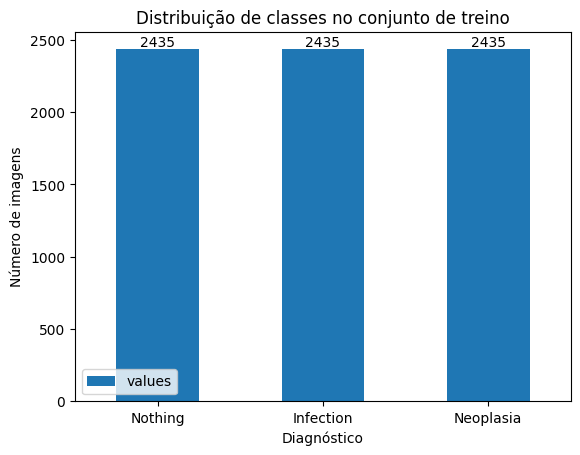

In [7]:
df_counter_train.plot(kind='bar', x='label', y='values', title='Distribuição de classes no conjunto de treino')
plt.xlabel('Diagnóstico')
plt.ylabel('Número de imagens')
plt.xticks(rotation=0)
#coloca valor na coluna
for index, value in enumerate(df_counter_train['values']):
    plt.text(index, value, str(value), ha='center', va='bottom')